<a href="https://colab.research.google.com/github/TKhahahah/Text_Analytics/blob/main/%E0%B8%AA%E0%B8%B3%E0%B9%80%E0%B8%99%E0%B8%B2%E0%B8%82%E0%B8%AD%E0%B8%87_Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ========== สีสำหรับกราฟ (วนใช้ทีละสี) ==========
from itertools import cycle

# แก้/เพิ่มสีได้ตามใจ (ชื่อสี matplotlib หรือโค้ด hex ก็ได้)
COLOR_CYCLE = cycle([
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf"
])

def next_color():
    return next(COLOR_CYCLE)

In [3]:
# ================================
# 📊 Quick Distribution Check (show plots inline)
# - สรุป dtype, missing, unique
# - ตัวเลข: percentiles, skew, kurtosis, normality test, IQR outliers
# - หมวดหมู่: Top-k counts
# - กราฟแสดงบนโน้ตบุ๊ก + บันทึกไฟล์
# ================================

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ---------- 1) ตั้งค่าไฟล์ ----------
DATA_PATH = '/content/drive/MyDrive/DTW2/cl1.parquet'  # <-- เปลี่ยนตามไฟล์จริง

if not DATA_PATH:
    raise SystemExit("กรุณากำหนด DATA_PATH ให้ถูกต้อง (รองรับ .csv / .parquet)")

ext = os.path.splitext(DATA_PATH)[1].lower()
if ext == '.csv':
    df = pd.read_csv(DATA_PATH)
elif ext == '.parquet':
    df = pd.read_parquet(DATA_PATH)
else:
    raise SystemExit("รองรับเฉพาะไฟล์ .csv และ .parquet เท่านั้น")

print("Loaded:", DATA_PATH, "Shape:", df.shape)
display(df.head(3))


# ---------- 2) ฟังก์ชันสรุป ----------
def summarize_dataframe(df: pd.DataFrame, max_cat_unique=50):
    rows = []
    for col in df.columns:
        s = df[col]
        dtype = s.dtype.name
        n = len(s)
        n_null = s.isna().sum()
        pct_null = (n_null / n * 100.0) if n > 0 else np.nan

        is_numeric = pd.api.types.is_numeric_dtype(s)
        nunique = s.nunique(dropna=True)
        is_categorical = (not is_numeric and nunique <= max_cat_unique) or (is_numeric and nunique <= 10)

        row = {
            "column": col,
            "dtype": dtype,
            "n": n,
            "n_missing": int(n_null),
            "pct_missing": round(pct_null, 2),
            "n_unique": int(nunique),
            "assumed_type": "numeric" if is_numeric and not is_categorical
                              else ("categorical" if is_categorical else "text/identifier")
        }

        if is_numeric and not is_categorical:
            desc = s.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])
            row.update({
                "mean": desc.get("mean", np.nan),
                "std": desc.get("std", np.nan),
                "min": desc.get("min", np.nan),
                "p01": desc.get("1%", np.nan),
                "p05": desc.get("5%", np.nan),
                "q25": desc.get("25%", np.nan),
                "q50": desc.get("50%", np.nan),
                "q75": desc.get("75%", np.nan),
                "p95": desc.get("95%", np.nan),
                "p99": desc.get("99%", np.nan),
                "max": desc.get("max", np.nan),
                "skew": s.skew(skipna=True),
                "kurtosis": s.kurtosis(skipna=True)
            })

            # Normality test (ใช้กับ n>=20)
            try:
                non_na = s.dropna().astype(float)
                if len(non_na) >= 20:
                    k2, p = stats.normaltest(non_na)
                    row.update({"normaltest_k2": float(k2), "normaltest_p": float(p)})
                else:
                    row.update({"normaltest_k2": np.nan, "normaltest_p": np.nan})
            except Exception:
                row.update({"normaltest_k2": np.nan, "normaltest_p": np.nan})

            # Outliers แบบ IQR
            q1, q3 = s.quantile(0.25), s.quantile(0.75)
            iqr = q3 - q1
            lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
            n_out = s[(s < lower) | (s > upper)].count()
            row.update({"iqr_outliers": int(n_out)})
        rows.append(row)
    return pd.DataFrame(rows)


# ---------- 3) ฟังก์ชันวาดกราฟ (แสดง + บันทึก) ----------
def plot_missing_bars(df: pd.DataFrame, out_path="dist_charts/missing_bar.png", show=True):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    miss = df.isna().mean().sort_values(ascending=False)
    plt.figure()
    miss.plot(kind="bar")
    plt.title("Missing ratio per column")
    plt.xlabel("Column")
    plt.ylabel("Missing ratio")
    plt.tight_layout()
    plt.savefig(out_path)
    if show:
        plt.show()
    plt.close()


def plot_numeric_histograms(
    df: pd.DataFrame,
    out_dir="dist_charts",
    preview_n=8,  # ตั้งเป็น None เพื่อวาดทุกคอลัมน์ตัวเลข
    show=True
):
    os.makedirs(out_dir, exist_ok=True)
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and df[c].nunique(dropna=True) > 10]
    if (preview_n is not None) and (len(num_cols) > preview_n):
        print(f"[Info] มีคอลัมน์ตัวเลข {len(num_cols)} คอลัมน์ — แสดงตัวอย่าง {preview_n} คอลัมน์แรก (ตั้ง preview_n=None เพื่อแสดงทั้งหมด)")
        num_cols = num_cols[:preview_n]

    for col in num_cols:
        s = df[col].dropna()
        if s.empty:
            continue
        plt.figure()
        plt.hist(s, bins=50)
        plt.title(f"Histogram: {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        out_path = os.path.join(out_dir, f"hist_{col}.png")
        plt.savefig(out_path)
        if show:
            plt.show()
        plt.close()


def plot_top_categories(
    df: pd.DataFrame,
    top_k=20,
    out_dir="dist_charts",
    preview_n=8,  # ตั้งเป็น None เพื่อวาดทุกคอลัมน์หมวดหมู่
    show=True
):
    os.makedirs(out_dir, exist_ok=True)
    cat_cols = []
    for c in df.columns:
        s = df[c]
        if pd.api.types.is_object_dtype(s) or pd.api.types.is_categorical_dtype(s) or (pd.api.types.is_numeric_dtype(s) and s.nunique() <= 10):
            cat_cols.append(c)

    if (preview_n is not None) and (len(cat_cols) > preview_n):
        print(f"[Info] มีคอลัมน์หมวดหมู่ {len(cat_cols)} คอลัมน์ — แสดงตัวอย่าง {preview_n} คอลัมน์แรก (ตั้ง preview_n=None เพื่อแสดงทั้งหมด)")
        cat_cols = cat_cols[:preview_n]

    for col in cat_cols:
        vc = df[col].astype("object").value_counts(dropna=False).head(top_k)
        if vc.empty:
            continue
        plt.figure()
        plt.bar(range(len(vc)), vc.values)
        plt.title(f"Top-{top_k} categories: {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(range(len(vc)), [str(k) for k in vc.index], rotation=45, ha="right")
        plt.tight_layout()
        out_path = os.path.join(out_dir, f"bar_{col}.png")
        plt.savefig(out_path)
        if show:
            plt.show()
        plt.close()


# ---------- 4) รันสรุป + แสดง/บันทึกผล ----------
summary = summarize_dataframe(df)
summary_path = "distribution_summary.csv"
summary.to_csv(summary_path, index=False)
print("Saved:", summary_path)
display(summary.head(10))

# กราฟ (ปรับ preview_n ได้ตามต้องการ)
plot_missing_bars(df, out_path="dist_charts/missing_bar.png", show=True)
plot_numeric_histograms(df, out_dir="dist_charts", preview_n=8, show=True)
plot_top_categories(df, top_k=20, out_dir="dist_charts", preview_n=8, show=True)

print("✓ กราฟถูกบันทึกในโฟลเดอร์ dist_charts/  (hist_*.png, bar_*.png, missing_bar.png)")
print("หมายเหตุ: สำหรับคอลัมน์ตัวเลข ให้ดู normaltest_p (ถ้า < 0.05 = ไม่เป็นปกติ), skew/kurtosis, และจำนวน IQR outliers")



Loaded: /content/drive/MyDrive/DTW2/cl1.parquet Shape: (10922072, 15)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,tip_amount,P_place,D_place,date,time,weekday,duration
0,2024-10-01 00:30:44,2024-10-01 00:48:26,1.0,3.0,1.0,162,246,18.4,1.5,Midtown East,West Chelsea/Hudson Yards,2024-10-01,0,Tuesday,17.700000
1,2024-10-01 00:12:20,2024-10-01 00:25:25,1.0,2.2,1.0,48,236,14.2,3.8,Clinton East,Upper East Side North,2024-10-01,0,Tuesday,13.083333
2,2024-10-01 00:04:46,2024-10-01 00:13:52,1.0,2.7,1.0,142,24,13.5,3.7,Lincoln Square East,Bloomingdale,2024-10-01,0,Tuesday,9.100000


KeyboardInterrupt: 

# แยกกราฟ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyarrow
import pyarrow.parquet as pq

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
taxi_data = pq.read_table('/content/drive/MyDrive/DTW2/cl1.parquet')
taxi_data = taxi_data.to_pandas()
taxi_data

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,tip_amount,P_place,D_place,date,time,weekday,duration
0,2024-10-01 00:30:44,2024-10-01 00:48:26,1.0,3.00,1.0,162,246,18.400000,1.50,Midtown East,West Chelsea/Hudson Yards,2024-10-01,0,Tuesday,17.700000
1,2024-10-01 00:12:20,2024-10-01 00:25:25,1.0,2.20,1.0,48,236,14.200000,3.80,Clinton East,Upper East Side North,2024-10-01,0,Tuesday,13.083333
2,2024-10-01 00:04:46,2024-10-01 00:13:52,1.0,2.70,1.0,142,24,13.500000,3.70,Lincoln Square East,Bloomingdale,2024-10-01,0,Tuesday,9.100000
3,2024-10-01 00:12:10,2024-10-01 00:23:01,1.0,3.10,1.0,233,75,14.200000,2.00,UN/Turtle Bay South,East Harlem South,2024-10-01,0,Tuesday,10.850000
4,2024-10-01 00:30:22,2024-10-01 00:30:39,1.0,0.00,1.0,262,262,3.000000,0.00,Yorkville East,Yorkville East,2024-10-01,0,Tuesday,0.283333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11148501,2024-12-31 23:21:36,2024-12-31 23:32:10,1.0,1.60,1.0,188,61,13.280000,0.00,Prospect-Lefferts Gardens,Crown Heights North,2024-12-31,23,Tuesday,10.566667
11148504,2024-12-31 23:14:53,2024-12-31 23:35:13,1.0,2.90,1.0,145,164,21.940001,0.00,Long Island City/Hunters Point,Midtown South,2024-12-31,23,Tuesday,20.333333
11148508,2024-12-31 23:03:16,2024-12-31 23:28:35,1.0,3.94,1.0,181,255,4.460000,5.19,Park Slope,Williamsburg (North Side),2024-12-31,23,Tuesday,25.316667
11148509,2024-12-31 23:15:33,2024-12-31 23:36:29,1.0,4.20,1.0,165,61,27.070000,0.00,Midwood,Crown Heights North,2024-12-31,23,Tuesday,20.933333


,proportion
RatecodeName_updated,
Standard rate,94.11
JFK,3.29
Other/Unknown,1.17
Negotiated fare,0.86
Newark,0.32
Nassau/Westchester,0.24
Group ride,0.00


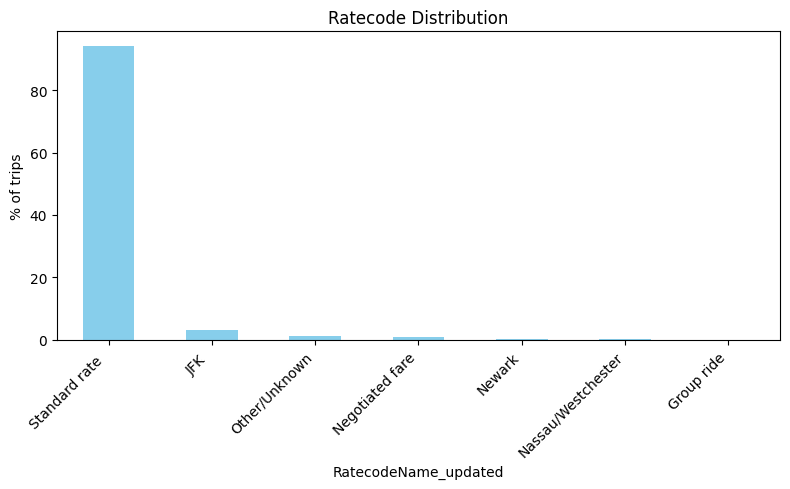

In [ ]:
# Mapping RatecodeID to RatecodeName
ratecode_mapping = {
    1.0: 'Standard rate',
    2.0: 'JFK',
    3.0: 'Newark',
    4.0: 'Nassau/Westchester',
    5.0: 'Negotiated fare',
    6.0: 'Group ride',
    99.0: 'Unknown'
}

# คำนวณสัดส่วน %
ratecode_distribution_updated = (
    taxi_data['RatecodeName_updated']
    .value_counts(normalize=True)
    * 100
).round(2)

# แสดงตาราง
display(ratecode_distribution_updated)

# วาดกราฟ
plt.figure(figsize=(8, 5))
ratecode_distribution_updated.plot(
    kind='bar',
    color='skyblue',
    title='Ratecode Distribution',
    ylabel='% of trips'
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


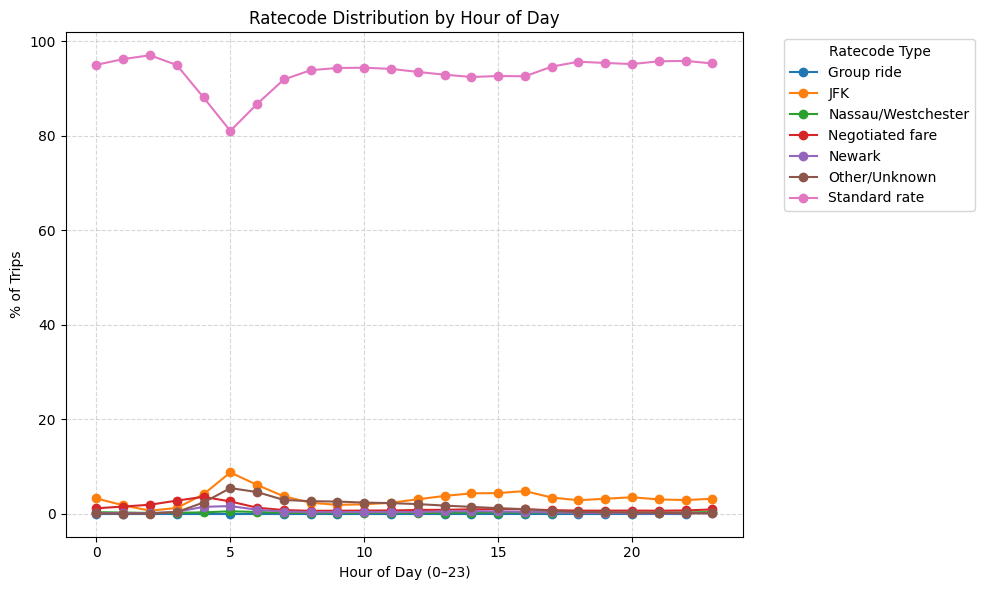

In [ ]:
# 1️⃣ แปลงเวลารับผู้โดยสารเป็นชั่วโมง
taxi_data['pickup_hour'] = pd.to_datetime(
    taxi_data['tpep_pickup_datetime'],
    errors='coerce'
).dt.hour

# 2️⃣ คำนวณจำนวนทริปของแต่ละ Ratecode ต่อชั่วโมง
hourly_counts = (
    taxi_data.groupby(['pickup_hour', 'RatecodeName_updated'])
    .size()
    .reset_index(name='trip_count')
)

# 3️⃣ แปลงให้เป็นสัดส่วน (%) ต่อชั่วโมง
hourly_counts['share_%'] = (
    hourly_counts.groupby('pickup_hour')['trip_count']
    .transform(lambda x: (x / x.sum()) * 100)
).round(2)

# 4️⃣ วาดกราฟเส้น แยกแต่ละประเภท Ratecode
plt.figure(figsize=(10,6))
for rate in hourly_counts['RatecodeName_updated'].unique():
    sub = hourly_counts[hourly_counts['RatecodeName_updated'] == rate]
    plt.plot(sub['pickup_hour'], sub['share_%'], marker='o', label=rate)

plt.title('Ratecode Distribution by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('% of Trips')
plt.legend(title='Ratecode Type', bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


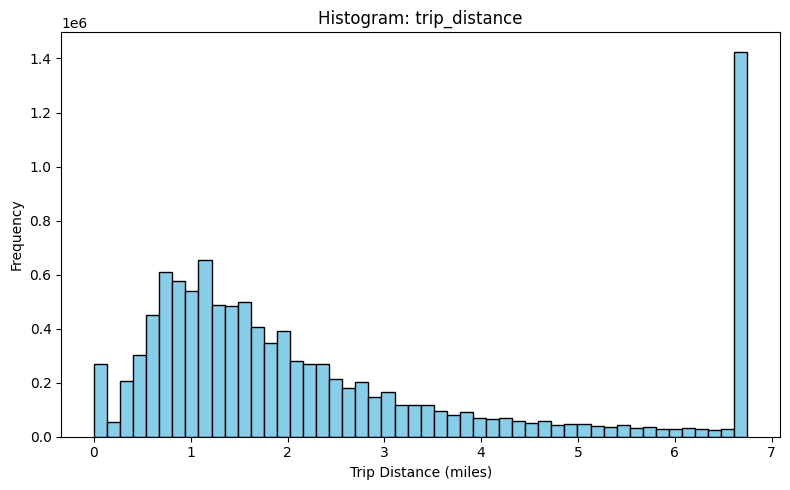

In [ ]:
# 🔹 สร้าง Histogram ของ trip_distance
plt.figure(figsize=(8, 5))
plt.hist(
    taxi_data['trip_distance'],
    bins=50,                 # จำนวนแท่ง (เพิ่ม-ลดความละเอียดได้)
    color='skyblue',         # สีของแท่งกราฟ
    edgecolor='black'        # เส้นขอบของแท่ง
)

# 🔹 ตั้งชื่อกราฟและแกน
plt.title('Histogram: trip_distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')

# 🔹 จัดระยะห่างให้อ่านง่าย
plt.tight_layout()
plt.show()

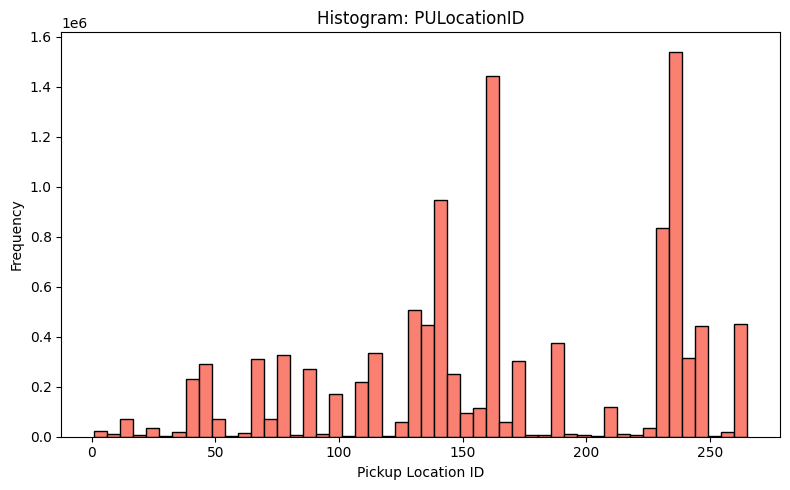

In [ ]:
# 🔹 สร้าง Histogram ของ PULocationID
plt.figure(figsize=(8, 5))
plt.hist(
    taxi_data['PULocationID'],
    bins=50,                  # จำนวนแท่ง (ปรับได้ตามจำนวนโซน)
    color='salmon',           # สีของแท่ง
    edgecolor='black'         # เส้นขอบของแท่ง
)

# 🔹 ตั้งชื่อกราฟและชื่อแกน
plt.title('Histogram: PULocationID')
plt.xlabel('Pickup Location ID')
plt.ylabel('Frequency')

# 🔹 จัด layout ให้อ่านง่าย
plt.tight_layout()
plt.show()

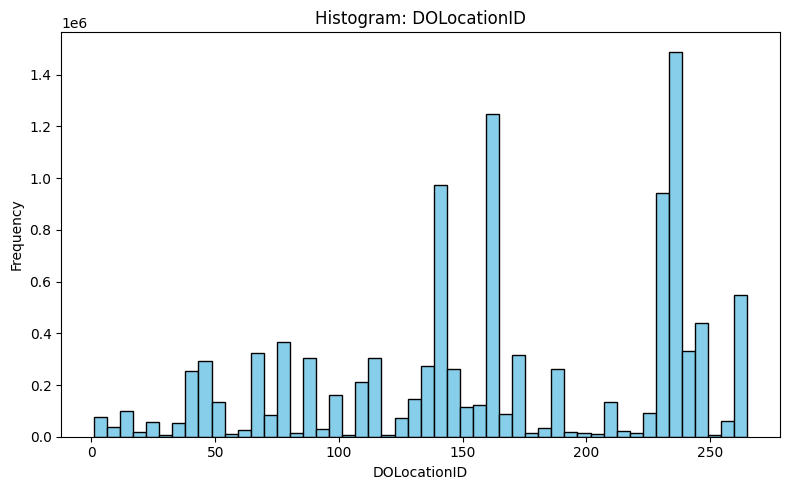

In [ ]:
# 🔹 Histogram ของ DOLocationID
plt.figure(figsize=(8, 5))
plt.hist(
    taxi_data['DOLocationID'],
    bins=50,                 # จำนวนแท่ง
    color='skyblue',         # สีของแท่ง
    edgecolor='black'        # เส้นขอบของแท่ง
)

# 🔹 ตั้งชื่อกราฟและชื่อแกน
plt.title('Histogram: DOLocationID')
plt.xlabel('DOLocationID')
plt.ylabel('Frequency')

# 🔹 จัด layout ให้อ่านง่าย
plt.tight_layout()
plt.show()

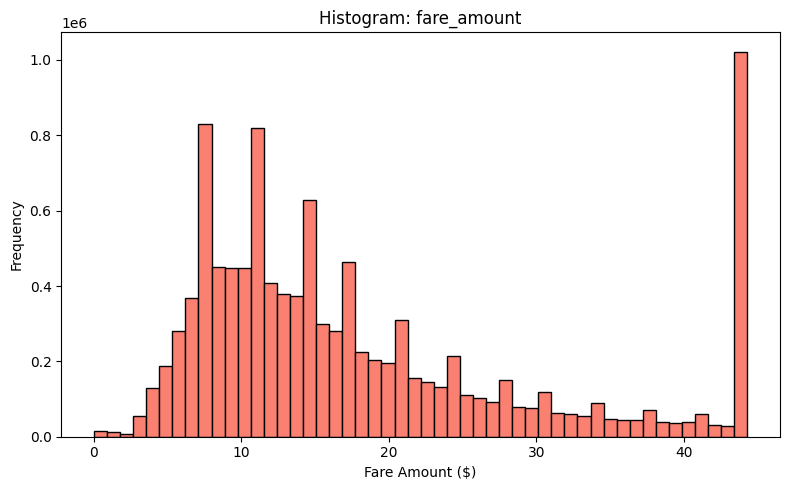

In [ ]:
# 🔹 Histogram ของค่าโดยสาร
plt.figure(figsize=(8, 5))
plt.hist(
    taxi_data['fare_amount'],
    bins=50,                 # จำนวนแท่ง (ยิ่งเยอะยิ่งละเอียด)
    color='salmon',          # สีของแท่ง
    edgecolor='black'        # เส้นขอบของแท่ง
)

# 🔹 ตั้งชื่อกราฟและชื่อแกน
plt.title('Histogram: fare_amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')

# 🔹 จัด layout ให้อ่านง่าย
plt.tight_layout()
plt.show()

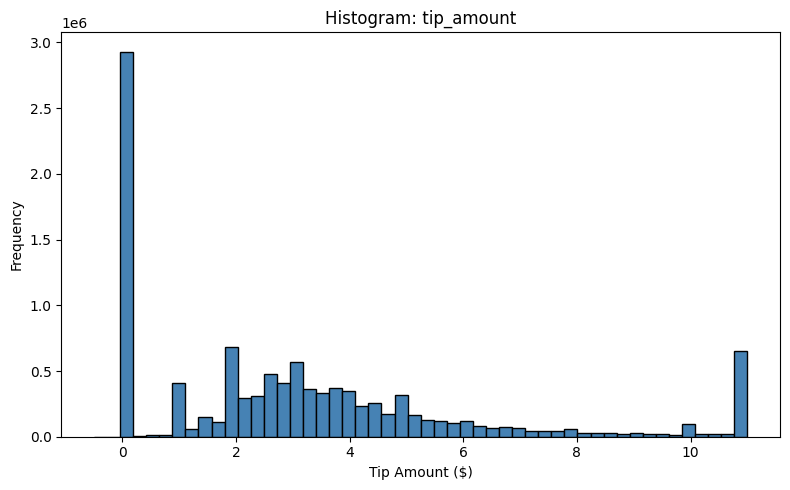

In [ ]:
# 🔹 สร้าง Histogram ของ tip_amount
plt.figure(figsize=(8, 5))
plt.hist(
    taxi_data['tip_amount'],
    bins=50,                 # จำนวนแท่งในกราฟ
    color='steelblue',       # สีของแท่ง
    edgecolor='black'        # เส้นขอบแท่ง
)

# 🔹 ตั้งชื่อกราฟและแกน
plt.title('Histogram: tip_amount')
plt.xlabel('Tip Amount ($)')
plt.ylabel('Frequency')

# 🔹 จัด layout ให้อ่านง่าย
plt.tight_layout()
plt.show()

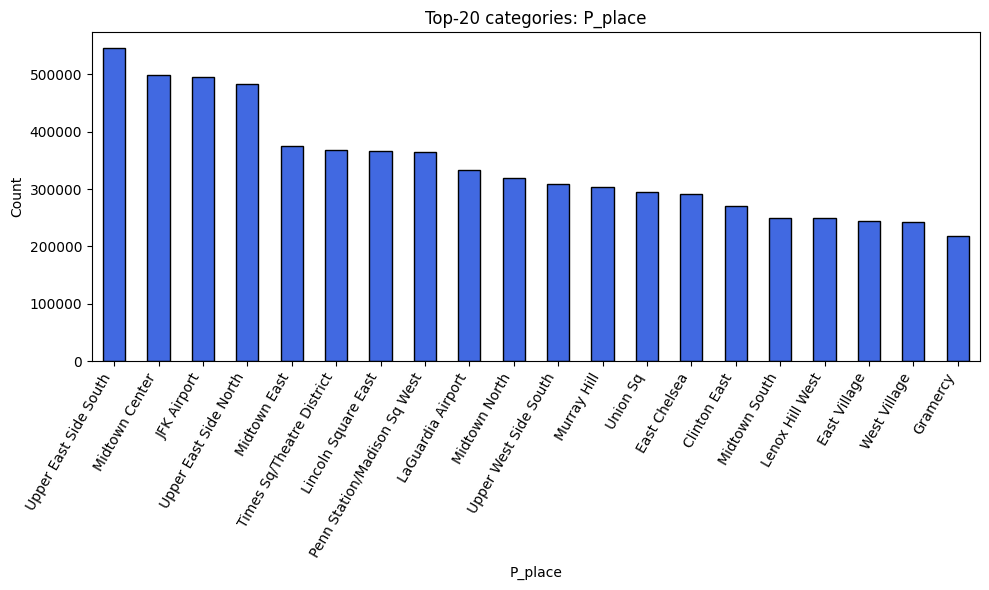

In [ ]:
# ✅ นับจำนวนการขึ้นรถในแต่ละพื้นที่
p_place_counts = taxi_data['P_place'].value_counts().head(20)

# ✅ วาดกราฟแท่ง
plt.figure(figsize=(10,6))
p_place_counts.plot(kind='bar', color='royalblue', edgecolor='black')
plt.title('Top-20 categories: P_place')
plt.xlabel('P_place')
plt.ylabel('Count')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

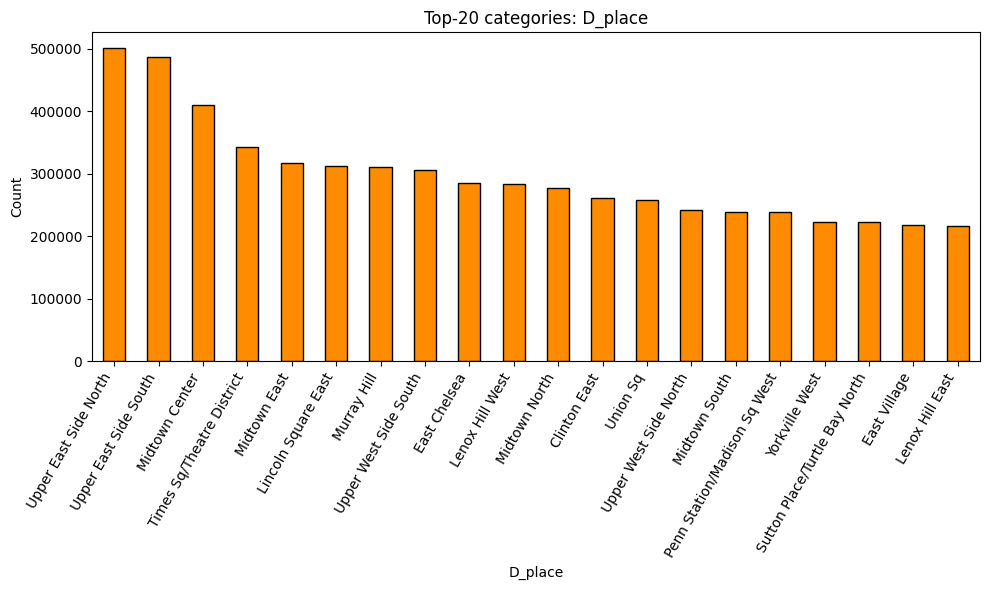

In [ ]:
# ✅ นับจำนวนการลงรถในแต่ละพื้นที่
d_place_counts =  taxi_data['D_place'].value_counts().head(20)

# ✅ วาดกราฟแท่ง
plt.figure(figsize=(10,6))
d_place_counts.plot(kind='bar', color='darkorange', edgecolor='black')
plt.title('Top-20 categories: D_place')
plt.xlabel('D_place')
plt.ylabel('Count')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [9]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [7]:
import pyarrow.parquet as pq
taxi_data = pq.read_table('/content/drive/MyDrive/DTW2/cleaned_final.parquet')
taxi_data = taxi_data.to_pandas()
taxi_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,tip_amount,tolls_amount,congestion_surcharge,Airport_fee,date,time,weekday,duration
0,2,2024-10-01 00:30:44,2024-10-01 00:48:26,1.0,3.00,1.0,162,246,18.400000,1.50,0.00,2.5,0.0,2024-10-01,0,Tuesday,17.700001
1,1,2024-10-01 00:12:20,2024-10-01 00:25:25,1.0,2.20,1.0,48,236,14.200000,3.80,0.00,2.5,0.0,2024-10-01,0,Tuesday,13.083333
2,1,2024-10-01 00:04:46,2024-10-01 00:13:52,1.0,2.70,1.0,142,24,13.500000,3.70,0.00,2.5,0.0,2024-10-01,0,Tuesday,9.100000
3,1,2024-10-01 00:12:10,2024-10-01 00:23:01,1.0,3.10,1.0,233,75,14.200000,2.00,0.00,2.5,0.0,2024-10-01,0,Tuesday,10.850000
5,2,2024-10-01 00:31:20,2024-10-01 00:36:00,2.0,0.97,1.0,137,137,7.200000,2.44,0.00,2.5,0.0,2024-10-01,0,Tuesday,4.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11148500,1,2024-12-31 23:42:33,2024-12-31 23:53:54,1.0,1.70,1.0,61,71,11.400000,0.00,0.00,2.5,0.0,2024-12-31,23,Tuesday,11.350000
11148501,1,2024-12-31 23:21:36,2024-12-31 23:32:10,1.0,1.60,1.0,188,61,13.280000,0.00,0.00,2.5,0.0,2024-12-31,23,Tuesday,10.566667
11148504,1,2024-12-31 23:14:53,2024-12-31 23:35:13,1.0,2.90,1.0,145,164,21.940001,0.00,6.94,2.5,0.0,2024-12-31,23,Tuesday,20.333334
11148508,2,2024-12-31 23:03:16,2024-12-31 23:28:35,1.0,3.94,1.0,181,255,4.460000,5.19,0.00,2.5,0.0,2024-12-31,23,Tuesday,25.316668


In [14]:
# Mapping RatecodeID to RatecodeName for better readability
ratecode_mapping = {
    1.0: 'Standard rate',
    2.0: 'JFK',
    3.0: 'Newark',
    4.0: 'Nassau/Westchester',
    5.0: 'Negotiated fare',
    6.0: 'Group ride',
    99.0: 'Unknown'
}
taxi_data['RatecodeName'] = taxi_data['RatecodeID'].map(ratecode_mapping).fillna('Other/Unknown')

# Create a  tip_amount by RatecodeName
plt.figure(figsize=(12, 6))
# tree map for correlation between trip_distance and tip_amount
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix[['trip_distance', 'tip_amount']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between trip_distance and tip_amount')

NameError: name 'correlation_matrix' is not defined

<Figure size 1200x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [15]:
# Calculate the correlation matrix
correlation_matrix = taxi_data.corr(numeric_only=True)
# Display the correlation matrix
display(correlation_matrix)


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,tip_amount,tolls_amount,congestion_surcharge,Airport_fee,time,duration
VendorID,1.000000,0.069583,0.042085,0.026530,-0.016686,-0.009804,0.051002,0.019534,0.022386,-0.012986,0.034500,0.013671,0.018246
passenger_count,0.069583,1.000000,0.045850,0.074027,-0.010399,-0.006478,0.054196,0.041843,0.044631,-0.006013,0.031810,0.033795,0.052438
trip_distance,0.042085,0.045850,1.000000,0.507804,-0.136099,-0.123963,0.936797,0.596460,0.667806,-0.297153,0.666533,-0.008636,0.778446
RatecodeID,0.026530,0.074027,0.507804,1.000000,-0.052790,-0.065966,0.552732,0.348141,0.462766,-0.181674,0.293576,-0.009101,0.374343
PULocationID,-0.016686,-0.010399,-0.136099,-0.052790,1.000000,0.069080,-0.131481,-0.064716,-0.080326,0.117813,-0.147830,0.012211,-0.112360
DOLocationID,-0.009804,-0.006478,-0.123963,-0.065966,0.069080,1.000000,-0.133900,-0.056617,-0.085852,0.145535,-0.050698,0.028904,-0.100398
fare_amount,0.051002,0.054196,0.936797,0.552732,-0.131481,-0.133900,1.000000,0.620005,0.653744,-0.288933,0.606241,0.009563,0.873250
tip_amount,0.019534,0.041843,0.596460,0.348141,-0.064716,-0.056617,0.620005,1.000000,0.500256,-0.140600,0.436139,0.037479,0.547841
tolls_amount,0.022386,0.044631,0.667806,0.462766,-0.080326,-0.085852,0.653744,0.500256,1.000000,-0.151517,0.489542,-0.014466,0.493578
congestion_surcharge,-0.012986,-0.006013,-0.297153,-0.181674,0.117813,0.145535,-0.288933,-0.140600,-0.151517,1.000000,-0.429394,-0.001900,-0.140261


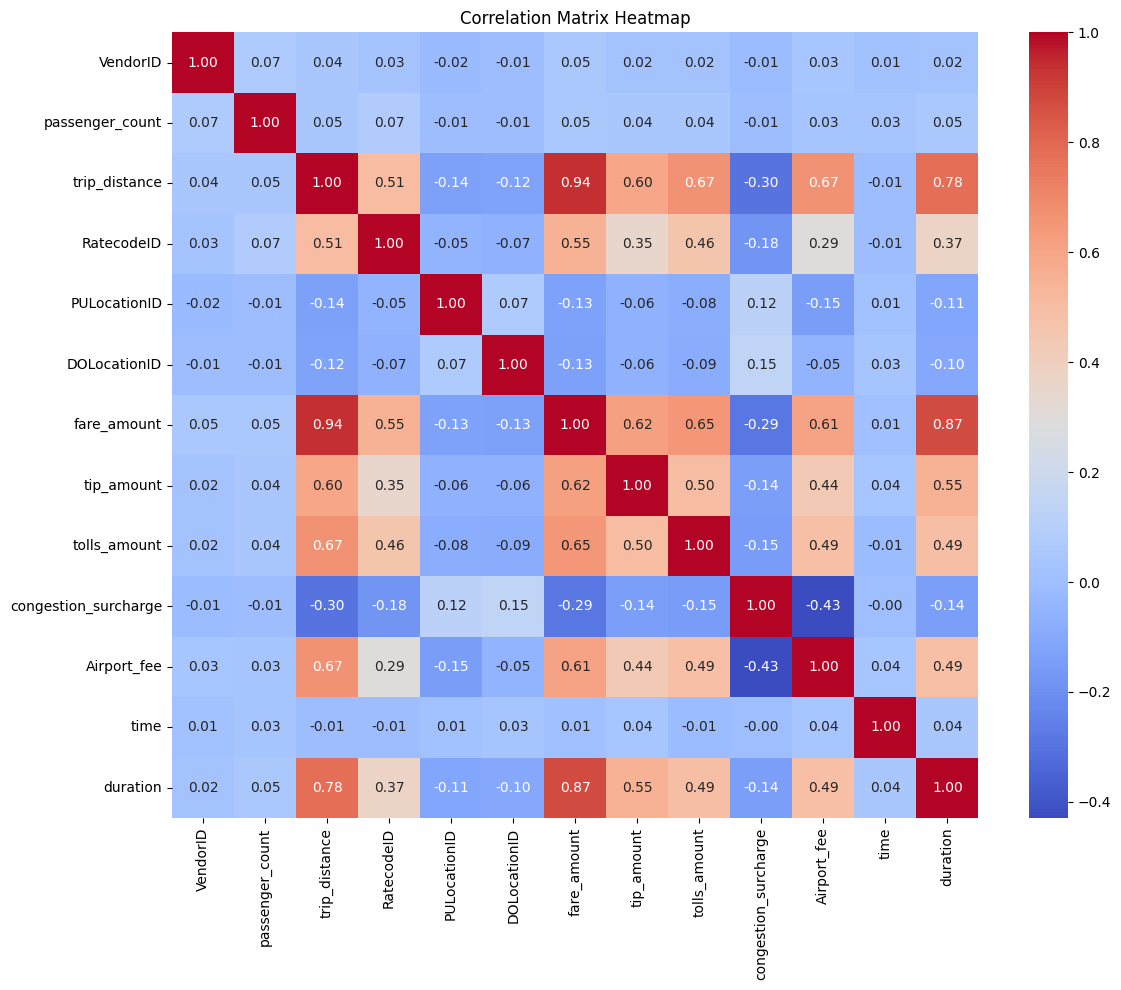

In [16]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

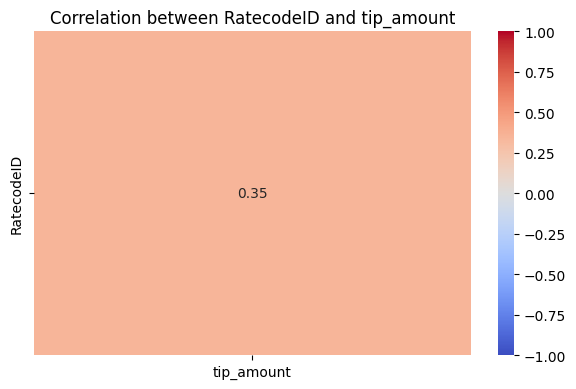

In [17]:
# Create a heatmap of the correlation between RatecodeID and tip_amount
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix.loc[['RatecodeID'], ['tip_amount']], annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation between RatecodeID and tip_amount')
plt.tight_layout()
plt.show()